In [1]:
!nvidia-smi

Sat Apr 29 17:52:44 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
| 57%   51C    P2              149W / 390W|    993MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# (1) Import necessary libraries

In [2]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

2023-04-29 17:52:44.343649: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-29 17:52:44.380400: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# (2) Download the datasets

# (3) Prepare the datasets

In [3]:
datasets = pd.read_csv("./datasets/medium_post_titles.csv")

In [4]:
datasets.head(3)

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False


### In here as I just focus on predicting the next word, so i'll only consider to use the title. This is in most cases you will find where you want to search something on google and there are some recommendation words that will come up, this is the idea of this projects.

In [5]:
datasets_title = datasets.title

In [6]:
datasets_title.head(3)

0    "21 Conversations" - A fun (and easy) game for...
1                         "Biblical Porn" at Mars Hill
2                    "CISGENDER?! Is That A Disease?!"
Name: title, dtype: object

# (4) Preprocess the data for training

### By default the Tokenizer will convert all the words to lowercase and generate an id for it

Before tokenize the sentences I want to add the starting and ending point of each sentence, so we will use it when to stop the text generation.

In [7]:
datasets_title_modified = datasets_title.apply(lambda x: "sevendi " + x + " poluan")

I also want to clean the data. Let's use regex for this case.

In [8]:
datasets_title_modified = datasets_title_modified.map(lambda x: ' ' . join(re.findall(r"[a-zA-Z]+", x)).lower())

In [9]:
datasets_title_modified[0]

'sevendi conversations a fun and easy game for teams to get to know each other poluan'

In [10]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<UNK>")

In [11]:
tokenizer.fit_on_texts(datasets_title_modified)

Show some sample results

In [12]:
tokenizer.texts_to_sequences([datasets_title_modified[5]])

[[2, 23493, 8, 711, 808, 4, 323, 1076, 569, 1565, 3]]

In [13]:
tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([datasets_title_modified[5]]))

['sevendi cypherpunks and wall street the security token revolution regulation poluan']

### We can sort all the words based on their frequencies

In [14]:
sorted_vocab = sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)

In [15]:
sorted_vocab[2:12] # word with most frequencies

[('the', 48206),
 ('to', 28115),
 ('a', 25614),
 ('of', 22701),
 ('and', 17984),
 ('in', 15510),
 ('s', 14857),
 ('how', 12786),
 ('is', 11945),
 ('for', 11126)]

In [16]:
sorted_vocab[-10:] #  word with least frequencies

[('herakitty', 1),
 ('snowplay', 1),
 ('kcleaner', 1),
 ('instagrammable', 1),
 ('kongers', 1),
 ('emitters', 1),
 ('foundries', 1),
 ('commandos', 1),
 ('amersfoort', 1),
 ('utrecht', 1)]

In [17]:
TOTAL_VOCABULARY = int(len(sorted_vocab))
TOTAL_VOCABULARY

42889

### Show all the words in a wordcloud to see each word frequencies as a whole text in the datasets

In [18]:
word_to_dict = dict(sorted_vocab[2:])

In [19]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10) # .generate(datasets_title)
wordcloud.fit_words(word_to_dict)

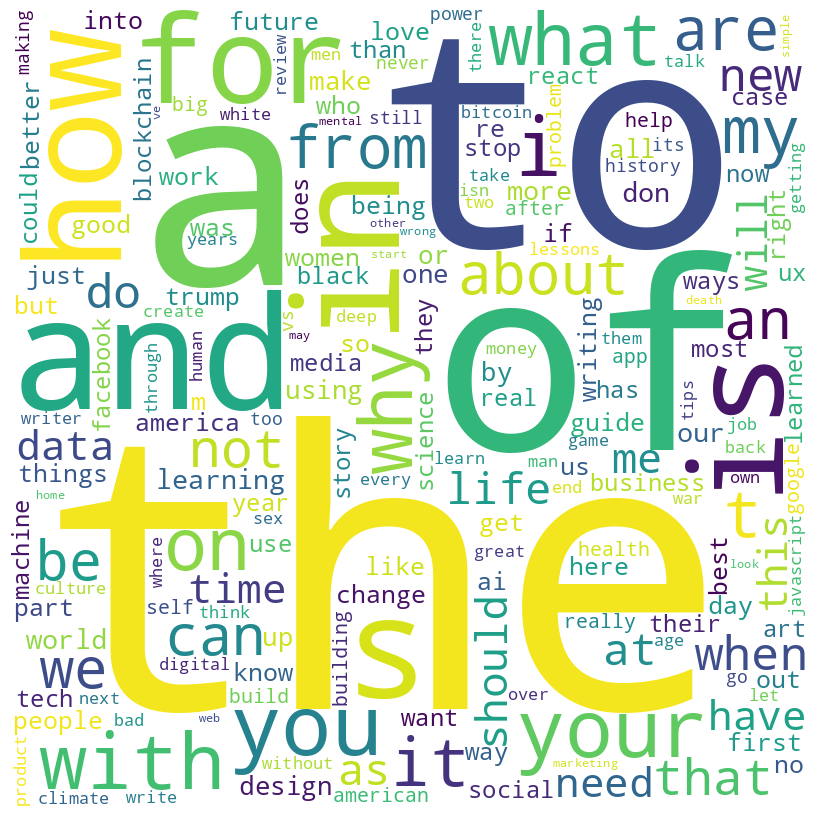

In [20]:
# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

The most common words are supposed to be the stop words in the sentences, but that's fine because we want to make a model for predicting the next words.

### Tokenize the data preparing for training and testing. In here i'll use multi-grams to build our datasets.

In [21]:
def n_gramize(data):
    n = 2
    sequences = []
    for x in data:
        to_sequence = np.squeeze(tokenizer.texts_to_sequences([x]))

        # multi-grams
        for y in range(len(to_sequence), n, -1):
            sequences.append(to_sequence[0:y])

        # n-grams
        # for i in range(n, len(to_sequence) + 1):
        #    seq = to_sequence[i-n:i]
        #    sequences.append(seq)
    return sequences

In [22]:
TOTAL_DATA = int(len(datasets_title_modified) * .2)

In [23]:
train_ds = n_gramize(datasets_title_modified.values[:-TOTAL_DATA])
test_ds = n_gramize(datasets_title_modified.values[-TOTAL_DATA:])

In [24]:
train_ds[:20]

[array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119,  194,    3]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119,  194]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72, 1119]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5,   72]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69,
           5]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,   69]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863,    5]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13,  863]),
 array([   2, 1790,    6,  762,    8,  405,  153,   13]),
 array([   2, 1790,    6,  762,    8,  405,  153]),
 array([   2, 1790,    6,  762,    8,  405]),
 array([   2, 1790,    6,  762,    8]),
 array([   2, 1790,    6,  762]),
 array([   2, 1790,    6]),
 array([   2, 7576, 15

### Check the maximum lenght for our available sequence data because we need to provide it to prepare for padding

In [25]:
max_length = max([max([len(seq) for seq in train_ds]), max([len(seq) for seq in test_ds])])

In [26]:
max_length

25

In [27]:
train_with_padding = tf.keras.preprocessing.sequence.pad_sequences(train_ds, maxlen=max_length, padding='pre')
test_with_padding = tf.keras.preprocessing.sequence.pad_sequences(test_ds, maxlen=max_length, padding='pre')

As we can see this will equalize our sequence to be the same length. So, for all the sequence that do not reach 20 will be replaced with 0.

In [28]:
train_with_padding[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    2, 1790,    6,  762,    8,  405,  153,   13,  863,    5,
         69,    5,   72], dtype=int32)

# (5) It's time to construct our training data

In [29]:
def func(sequence_data):
    attention_mask = tf.cast(tf.not_equal(sequence_data[:-1], 0), tf.int32)
    # one_hot = tf.one_hot(sequence_data[-1], TOTAL_VOCABULARY, axis=0) # cost memory
    return sequence_data[:-1], sequence_data[-1]

In [30]:
train_tf = tf.data.Dataset.from_tensor_slices(train_with_padding)
test_tf = tf.data.Dataset.from_tensor_slices(test_with_padding)

2023-04-29 17:52:52.921043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21253 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [31]:
BATCH_SIZE = 32

In [32]:
train = train_tf.map(func).cache().prefetch(tf.data.AUTOTUNE).shuffle(buffer_size=1000).batch(BATCH_SIZE)
test = test_tf.map(func).prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

# (6) Build a simple model

In [47]:
def create_model():
     
    embedding = tf.keras.layers.Embedding(input_dim=TOTAL_VOCABULARY, output_dim=1024, input_length=max_length, name="embedding")
    
    inputs = tf.keras.layers.Input(shape=(max_length - 1,), name="inputs") # minus 1 because the last index has been made as a label
    
    x = embedding(inputs)  
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=False))(x)  
    x = tf.keras.layers.Dense(2048, activation="relu")(x)  
    outputs = tf.keras.layers.Dense(TOTAL_VOCABULARY, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(lr=0.00001),
                  metrics=["accuracy"])
    model.summary()
    return model

# (7) Train our model

In [48]:
model = create_model()

2023-04-29 17:53:52.159770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 17:53:52.161427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 17:53:52.162389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 1024)          43918336  
                                                                 
 bidirectional_2 (Bidirectio  (None, 2048)             16785408  
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_5 (Dense)             (None, 42889)             87879561  
                                                                 
Total params: 152,779,657
Trainable params: 152,779,657
Non-trainable params: 0
_____________________________________________

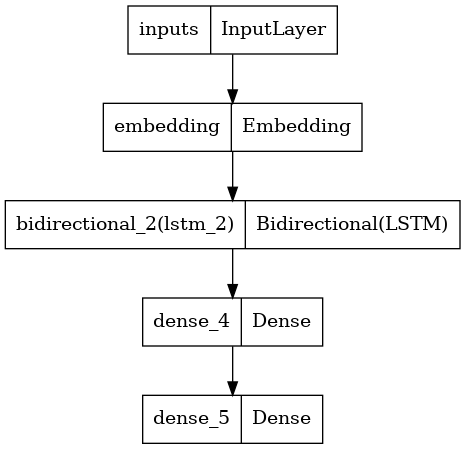

In [49]:
tf.keras.utils.plot_model(model)

In [50]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", patience="7", start_from_epoch=0)

In [51]:
class ModelCheckpointCustom(tf.keras.callbacks.Callback):
    
    def __init__(self, model_path, save_best_only=False):
        super(ModelCheckpointCustom, self).__init__()
         
        self.model_path = model_path
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf') 

    def on_epoch_end(self, epoch, logs=None):
        
        print('\rlogs: ', logs, '\r')
        
        current_val_loss = 0 if logs['val_loss'] is None else logs['val_loss']
        
        print('\rcurrent_val_loss: ', current_val_loss, '\r')
        print('\rsave_best_only: ', self.save_best_only, '\r')
        print('\rbest_val_loss: ', self.best_val_loss, '\r')
        print('\rcurrent_val_loss < best_val_loss: ', current_val_loss < self.best_val_loss, '\r') 
        
        if self.save_best_only and current_val_loss < self.best_val_loss:
            print('\rSaving weights at (save_best_only=True): ', self.model_path, '\r')
            self.best_val_loss = current_val_loss 
            self.model.save_weights(self.model_path)
            print("\rModel has been saved!")
        else:
            print('\rSaving weights at (save_best_only=False): ', self.model_path, '\r')
            self.model.save_weights(self.model_path) 
            print("\rModel has been saved!")

save_callbacks = ModelCheckpointCustom(model_path='saved_weights/model.weights.h5', save_best_only=True)

In [52]:
# model.load_weights("saved_weights/model.weights.h5")

In [ ]:
history = model.fit(train, epochs=100, validation_data=test, validation_steps=len(test) * .2, callbacks=[save_callbacks, early_stop])

Epoch 1/100


2023-04-29 17:53:52.964708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 17:53:52.966338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-29 17:53:52.967325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24586/24586 [==============================] - ETA: 0s - loss: 6.3403 - accuracy: 0.2048

2023-04-29 18:03:17.913113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [212970,25]
	 [[{{node Placeholder/_0}}]]
2023-04-29 18:03:18.112829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-29 18:03:18.113912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tenso

logs:  {'loss': 6.340275764465332, 'accuracy': 0.20476165413856506, 'val_loss': 6.392016410827637, 'val_accuracy': 0.1829720288515091} 
current_val_loss:  6.392016410827637 
save_best_only:  True 
best_val_loss:  inf 
current_val_loss < best_val_loss:  True 
Saving weights at (save_best_only=True):  saved_weights/model.weights.h5 
Model has been saved!
24586/24586 [==============================] - 582s 24ms/step - loss: 6.3403 - accuracy: 0.2048 - val_loss: 6.3920 - val_accuracy: 0.1830
Epoch 2/100
logs:  {'loss': 5.9066972732543945, 'accuracy': 0.22337888181209564, 'val_loss': 6.474674701690674, 'val_accuracy': 0.19648554921150208} 
current_val_loss:  6.474674701690674 
save_best_only:  True 
best_val_loss:  6.392016410827637 
current_val_loss < best_val_loss:  False 
Saving weights at (save_best_only=False):  saved_weights/model.weights.h5 
Model has been saved!
24586/24586 [==============================] - 559s 23ms/step - loss: 5.9067 - accuracy: 0.2234 - val_loss: 6.4747 - val_a

# (8) Save the model weights

In [ ]:
# model.save_weights("model.weights.h5")

# (9) Plot the training performance

In [ ]:
pd.DataFrame(history.history).plot()

### <font color="brown">The accuracy of predicting the next words is often low due to several factors. In the case of our model, the primary reason is the large number of target predictions it must make. With 42889 different classes representing the 42889 unique words in our vocabulary, the model is forced to differentiate between a large number of possibilities. Additionally, the dataset used for training may not be large enough to effectively capture the intricacies of the language, leading to low accuracy. Another contributing factor may be the high imbalance in the dataset, which can lead to overfitting and reduced generalization. Therefore, addressing these issues, such as increasing the size of the dataset, balancing the classes, and incorporating more advanced models, may help to improve the accuracy of our language prediction model.</font>